In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import Adam
from torchvision.transforms import transforms, Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torch.utils.data import DataLoader, random_split
from tools.models import *
import matplotlib.pyplot as plt
import numpy as np
import random
import imageio
from argparse import ArgumentParser
import einops


# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"./history/ddpm_model_mnist.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
train_losses = []
test_losses = []


def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps
    for epoch in range(num_epochs):
        train_loss = 0
        for data in train_dataloader:
            # Loading data
            x0 = data[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta, _ = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            train_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {train_loss:.3f}"
    
        # Storing the model
        if best_loss > train_loss:
            best_loss = train_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

            # Evaluation on the test set
#     test_loss = 0.0
#     with torch.no_grad():
#         for data in test_dataloader:
#             inputs, _ = data
#             inputs = inputs.view(inputs.size(0), -1)
        
#             # Forward pass through the autoencoder
#             outputs = autoencoder(inputs)
        
#             # Calculate the test loss
#             loss = criterion(outputs, inputs)
#             test_loss += loss.item()

#     # Calculate average test loss for the epoch
#     test_loss /= len(test_dataloader)
#     test_losses.append(test_loss)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')
        

# # Plot the training and test losses
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
# plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.title('Autoencoder Training and Test Losses')
# plt.show()

In [ ]:
feature_maps = model.feature_maps
# Upsample and concatenate feature maps
concat_feature_maps = model.feature_extract(feature_maps, original_size=(28, 28))

pred = AE(concat_feature_maps)
optim = Adam

criterion = MSE

AE.complie(loss=criterion)

In [68]:
# Hyperparameters
dataset = "MNIST"
store_path = f"./history/ddpm_{dataset}.pt"
batch_size = 128
learning_rate = 0.001
num_epochs = 20

# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
ds_fn = MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
train_dataloader = DataLoader(dataset, batch_size, shuffle=True)

# if dataset == "MNIST":
#     # Load the MNIST dataset and split into training and testing sets
#     transform = transforms.Compose([transforms.ToTensor()])
#     mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

#     # Split the dataset into 1000 training and 200 testing
#     # Define the sizes for train, validation, and test sets
#     train_size = 1000
#     val_size = len(mnist_dataset) - train_size - 200  # The rest goes to the validation set
#     test_size = 200

#     # Use random_split to create the datasets
#     train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

# # Create data loaders for training and testing
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the autoencoder
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
model = DDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loop(model, train_dataloader, num_epochs, optimizer, device, store_path=store_path)

34.0%

100.0%


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100.0%
95.4%


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100.0%
100.0%


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Loss at epoch 1: 0.174 --> Best model ever (stored)
Loss at epoch 2: 0.049 --> Best model ever (stored)
Loss at epoch 3: 0.041 --> Best model ever (stored)
Loss at epoch 4: 0.038 --> Best model ever (stored)
Loss at epoch 5: 0.036 --> Best model ever (stored)
Loss at epoch 6: 0.035 --> Best model ever (stored)
Loss at epoch 7: 0.034 --> Best model ever (stored)
Loss at epoch 8: 0.034 --> Best model ever (stored)
Loss at epoch 9: 0.033 --> Best model ever (stored)
Loss at epoch 10: 0.032 --> Best model ever (stored)
Loss at epoch 11: 0.032 --> Best model ever (stored)
Loss at epoch 12: 0.031 --> Best model ever (stored)
Loss at epoch 13: 0.031 --> Best model ever (stored)
Loss at epoch 14: 0.031 --> Best model ever (stored)
Loss at epoch 15: 0.030 --> Best model ever (stored)
Loss at epoch 16: 0.030 --> Best model ever (sto

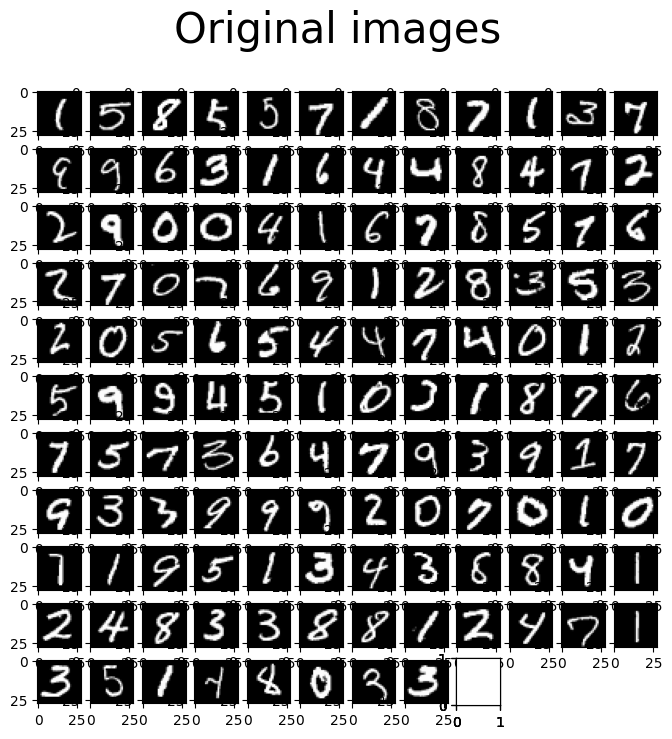

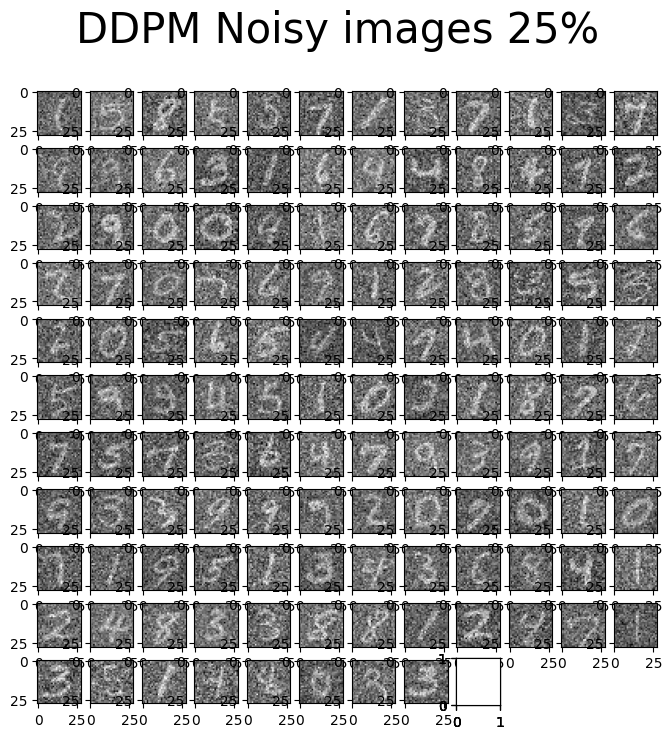

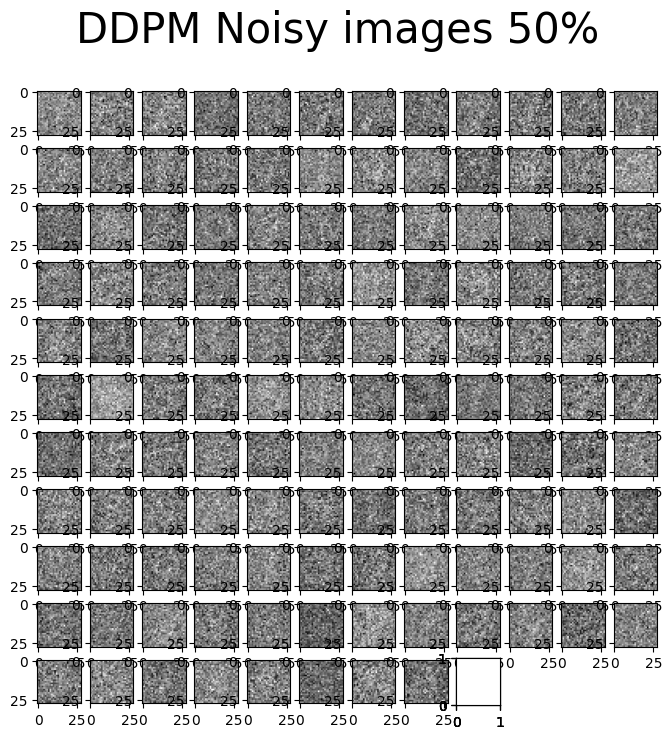

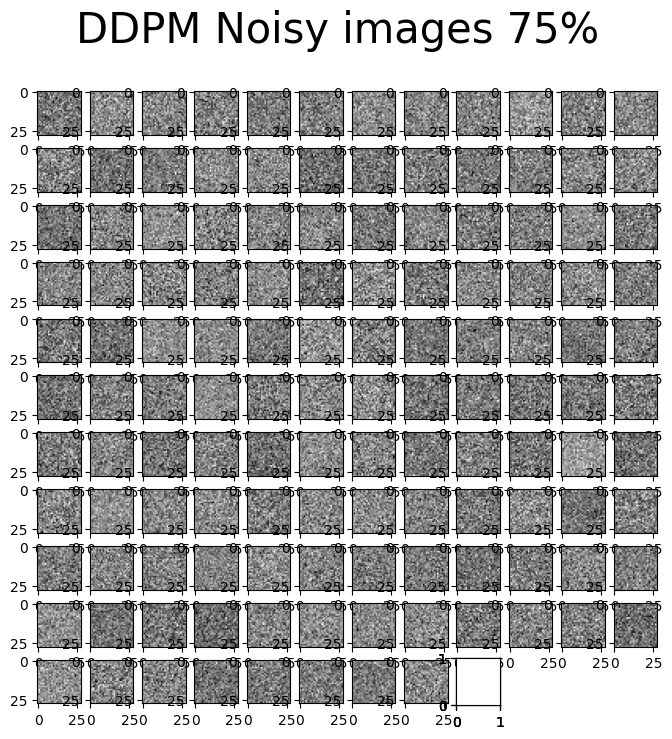

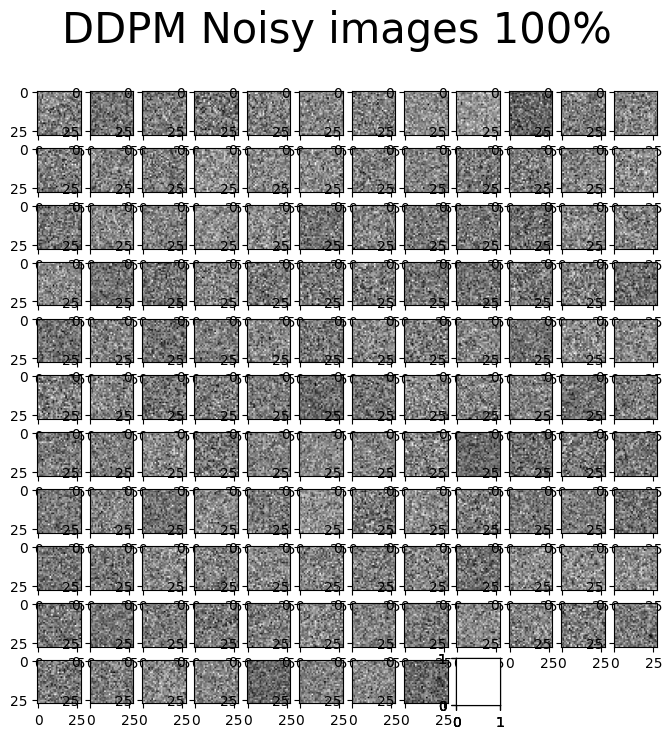

In [69]:
show_forward(model, train_dataloader, device)

Model loaded
Generating new images


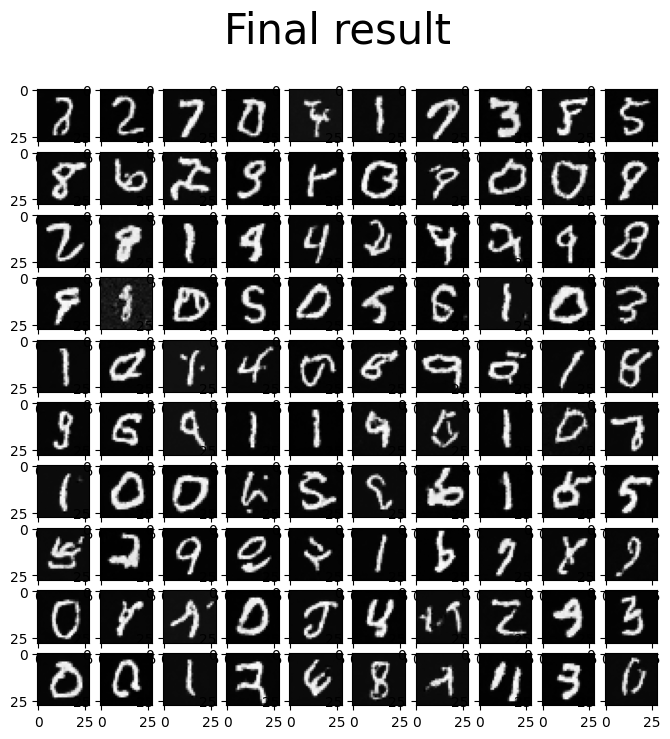

In [70]:
# Loading the trained model
best_model = DDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="mnist.gif"
    )
show_images(generated, "Final result")

In [71]:
# Visual evaluation on the test set
with torch.no_grad():
    for data in test_dataloader:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)
        
        # Forward pass through the autoencoder
        outputs = autoencoder(inputs)
        
        # Reshape the outputs to the original image shape (28x28)
        outputs = outputs.view(outputs.size(0), 1, 28, 28)
        
        # Convert Tensors to NumPy arrays for visualization
        inputs = inputs.view(inputs.size(0), 1, 28, 28).numpy()
        outputs = outputs.numpy()
        
        # Plot the input and output images
        for i in range(inputs.shape[0]):
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.title('Input Image')
            plt.imshow(np.squeeze(inputs[i]), cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.title('Output Image')
            plt.imshow(np.squeeze(outputs[i]), cmap='gray')
            plt.axis('off')
            plt.show()

NameError: name 'autoencoder' is not defined